In [1]:
import os
import random
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, f1_score
from sklearn.calibration import CalibratedClassifierCV

In [2]:
# imbalanced-learn pipeline and SMOTE
try:
    from imblearn.pipeline import Pipeline as ImbPipeline
    from imblearn.over_sampling import SMOTE
except Exception as e:
    raise ImportError("Install imbalanced-learn: pip install imbalanced-learn") from e

#for reproducability
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    # torch seeds would go here if using pytorch
set_seed(42)


## Data Importing

In [3]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/happy522/Argument-Mining/refs/heads/main/AM_gelabeled-2.csv")
df
keep_classes = [
    "Prämisse",
    "Behauptung",
    "Schlussfolgerung",
    "Nicht-argumentativer Text"
]

# Remove leading "/" in case your labels look like "/Zurückweisung"
df["Label"] = df["Label"].str.replace("/", "", regex=False).str.strip()

# Filter DataFrame
filtered_df = df[df["Label"].isin(keep_classes)]

# Classes you want to keep


# Reset index if needed
df = filtered_df.reset_index(drop=True)

print(df)

      Unnamed: 0                                         Komponente  \
0             10  Die Redebeiträge machten deutlich: egal welche...   
1             11  Unsere Grundwerte, geprägt von Solidarität, Fr...   
2             12  \tUnsere Demokratie ist bedroht. Vielleicht wa...   
3             13  Jetzt steht Correctiv vor Gericht und die Poli...   
4             14          Die Würde des Menschen ist unantastbar.\n   
...          ...                                                ...   
1068        1087  Theresienstadt führte. Im Oktober 1944 wurde P...   
1069        1088  Albrecht Weinberg, 98, hat Bergen-Belsen und A...   
1070        1089  ? Wir stehen gemeinsam für Solidarität mit Isr...   
1071        1090  Auch wir waren und sind Teil der #BrandmauerGe...   
1072        1091  Endlich können wir teilen, woran wir im Bündni...   

                          Label  
0                      Prämisse  
1                      Prämisse  
2                      Prämisse  
3          

##Label encoding

In [4]:
if "Komponente" in df.columns and "Label" in df.columns:
    df = df.rename(columns={"Komponente": "text", "Label": "label"})
elif "text" not in df.columns or "label" not in df.columns:
    raise ValueError("DataFrame must contain 'Komponente'/'text' and 'Label'/'label' columns.")

# Encode labels (and keep mapping)
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])
print("Classes:", list(le.classes_))

Classes: ['Behauptung', 'Nicht-argumentativer Text', 'Prämisse', 'Schlussfolgerung']


##Train-test classification

In [5]:

X_texts = df['text'].astype(str).values
y = df['label_enc'].values

X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    X_texts, y, test_size=0.2, stratify=y, random_state=42
) # startify: training and testing sets have the same proportion of classes (or labels)

print(f"Train size: {len(X_train_texts)}, Test size: {len(X_test_texts)}")

# Validation
X_train_texts, X_val_texts, y_train, y_val = train_test_split(
    X_train_texts, y_train, test_size=0.15, stratify=y_train, random_state=42
)
print(f"After split -> Train: {len(X_train_texts)}, Val: {len(X_val_texts)}, Test: {len(X_test_texts)}")


Train size: 858, Test size: 215
After split -> Train: 729, Val: 129, Test: 215


##SBERT embedding and storing

In [6]:
EMB_CACHE_DIR = "embeddings_cache"
os.makedirs(EMB_CACHE_DIR, exist_ok=True)
model_name = 'deepset/gbert-base'
sbert_cache_prefix = os.path.join(EMB_CACHE_DIR, model_name.replace("/", "_"))

model = SentenceTransformer(model_name)

def encode_and_cache(texts, fname):
    if os.path.exists(fname):
        print(f"Loading cached embeddings from {fname}")
        return np.load(fname)
    print(f"Encoding {len(texts)} texts and saving to {fname} ...")
    emb = model.encode(list(texts), convert_to_numpy=True, show_progress_bar=True, batch_size=64)
    np.save(fname, emb)
    return emb

X_train = encode_and_cache(X_train_texts, sbert_cache_prefix + "_train.npy")
X_val   = encode_and_cache(X_val_texts,   sbert_cache_prefix + "_val.npy")
X_test  = encode_and_cache(X_test_texts,  sbert_cache_prefix + "_test.npy")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/362 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/83.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Encoding 729 texts and saving to embeddings_cache/deepset_gbert-base_train.npy ...


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Encoding 129 texts and saving to embeddings_cache/deepset_gbert-base_val.npy ...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Encoding 215 texts and saving to embeddings_cache/deepset_gbert-base_test.npy ...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

#Cross validation and pipeline

- Imbalanced-learn pipeline SMOTE will be applied only on training folds.
- StandardScaler because some models (SVC, KNN, Logistic) benefit from scaled embeddings.

In [7]:
#crossvalidation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def make_pipeline(clf):
    return ImbPipeline([
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=42)),
        ("clf", clf)
    ])

# Defining classifiers and modest param grids
models_and_grids = [
    (make_pipeline(LogisticRegression(max_iter=2000, random_state=42)),
     {"clf__C":[0.01,0.1,1,10], "clf__solver":["saga","lbfgs"], "clf__class_weight":[None,"balanced"]}),

    (make_pipeline(SVC(probability=True, random_state=42)),
     {"clf__C":[0.1,1,10], "clf__kernel":["linear","rbf"], "clf__gamma":["scale","auto"]}),

    (make_pipeline(RandomForestClassifier(random_state=42)),
     {"clf__n_estimators":[100,200], "clf__max_depth":[None,20], "clf__class_weight":[None,"balanced"]}),

    (make_pipeline(KNeighborsClassifier()),
     {"clf__n_neighbors":[3,5,7], "clf__weights":["uniform","distance"], "clf__metric":["euclidean","manhattan"]})
]


In [8]:
# GridSearchCV for each model (using StratifiedKFold), saving results
best_models = {}
all_cv_results = {}

for pipe, param_grid in models_and_grids:
    clf_name = pipe.named_steps['clf'].__class__.__name__
    print(f"\n--- Running GridSearchCV for {clf_name} ---")
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=cv,
        scoring="f1_macro",
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )
    grid.fit(X_train, y_train)
    print("Best Params:", grid.best_params_)
    print("Best CV f1_macro:", grid.best_score_)
    best_models[clf_name] = grid.best_estimator_
    # Save results
    all_cv_results[clf_name] = pd.DataFrame(grid.cv_results_)
    all_cv_results[clf_name].to_csv(f"{clf_name}_cv_results.csv", index=False)
    joblib.dump(grid.best_estimator_, f"{clf_name}_best_pipeline.joblib")
    print(f"Saved {clf_name}_best_pipeline.joblib and CV results csv.")


--- Running GridSearchCV for LogisticRegression ---
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Params: {'clf__C': 0.01, 'clf__class_weight': None, 'clf__solver': 'lbfgs'}
Best CV f1_macro: 0.4832730168391756
Saved LogisticRegression_best_pipeline.joblib and CV results csv.

--- Running GridSearchCV for SVC ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Params: {'clf__C': 10, 'clf__gamma': 'auto', 'clf__kernel': 'rbf'}
Best CV f1_macro: 0.452275736434428
Saved SVC_best_pipeline.joblib and CV results csv.

--- Running GridSearchCV for RandomForestClassifier ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Params: {'clf__class_weight': None, 'clf__max_depth': 20, 'clf__n_estimators': 100}
Best CV f1_macro: 0.47481950163409187
Saved RandomForestClassifier_best_pipeline.joblib and CV results csv.

--- Running GridSearchCV for KNeighborsClassifier ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Params: {

#Evaluation
- classification report
- confusion matrix
- misclassifications


=== Evaluation for LogisticRegression ===
                           precision    recall  f1-score   support

               Behauptung       0.57      0.48      0.52        25
Nicht-argumentativer Text       0.91      0.94      0.93        79
                 Prämisse       0.46      0.48      0.47        23
         Schlussfolgerung       0.33      0.50      0.40         2

                 accuracy                           0.76       129
                macro avg       0.57      0.60      0.58       129
             weighted avg       0.76      0.76      0.76       129



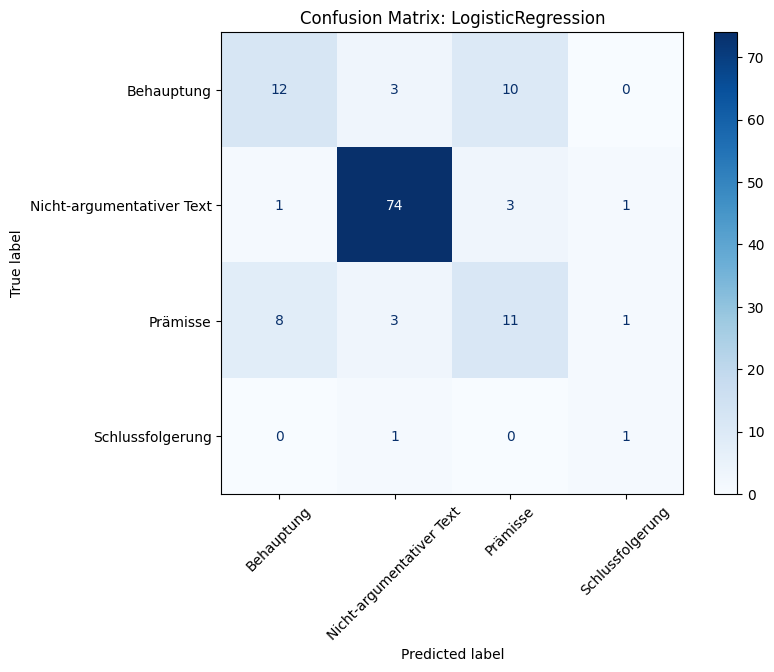

Number of misclassifications: 31

=== Evaluation for LogisticRegression ===
                           precision    recall  f1-score   support

               Behauptung       0.44      0.37      0.40        41
Nicht-argumentativer Text       0.90      0.92      0.91       132
                 Prämisse       0.46      0.49      0.47        39
         Schlussfolgerung       0.50      0.67      0.57         3

                 accuracy                           0.73       215
                macro avg       0.58      0.61      0.59       215
             weighted avg       0.73      0.73      0.73       215



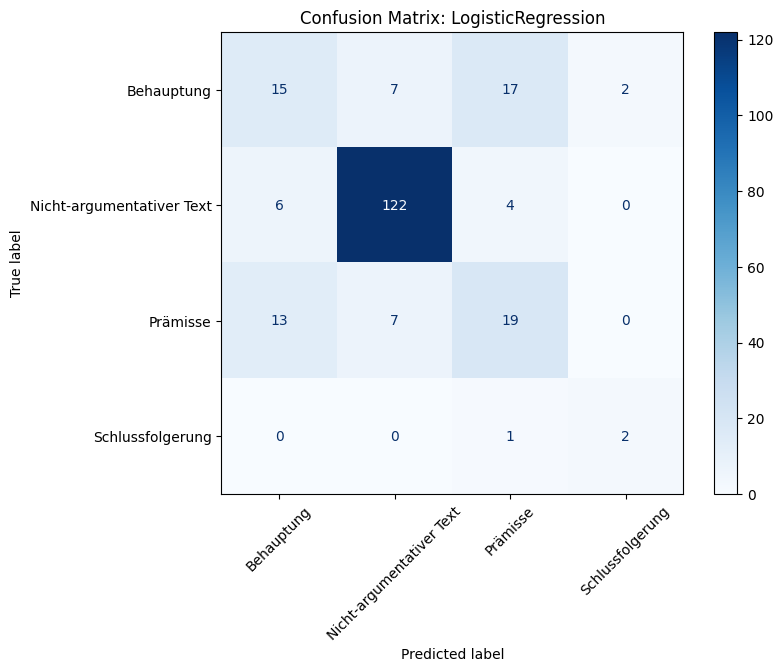

Number of misclassifications: 57

=== Evaluation for SVC ===
                           precision    recall  f1-score   support

               Behauptung       0.54      0.52      0.53        25
Nicht-argumentativer Text       0.91      0.95      0.93        79
                 Prämisse       0.55      0.52      0.53        23
         Schlussfolgerung       1.00      0.50      0.67         2

                 accuracy                           0.78       129
                macro avg       0.75      0.62      0.67       129
             weighted avg       0.78      0.78      0.78       129



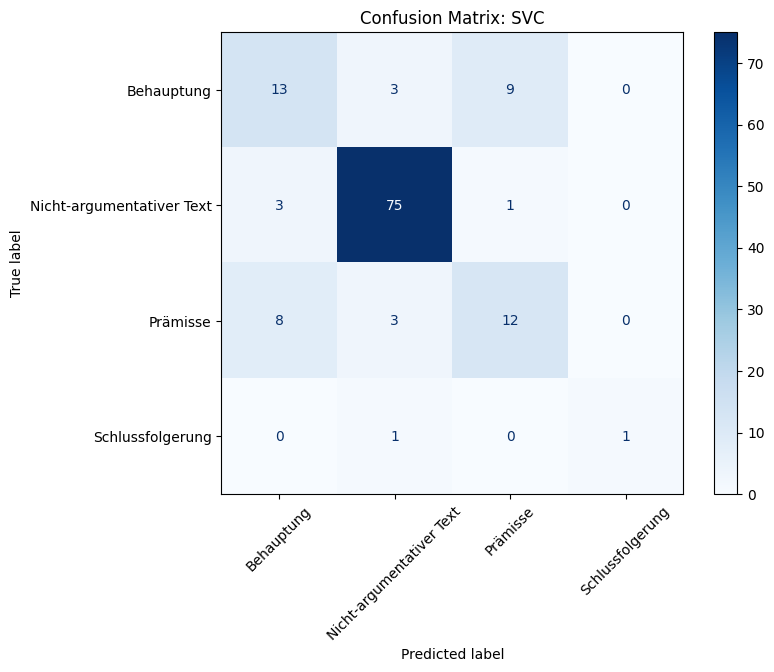

Number of misclassifications: 28

=== Evaluation for SVC ===
                           precision    recall  f1-score   support

               Behauptung       0.45      0.41      0.43        41
Nicht-argumentativer Text       0.89      0.94      0.92       132
                 Prämisse       0.44      0.41      0.43        39
         Schlussfolgerung       1.00      0.67      0.80         3

                 accuracy                           0.74       215
                macro avg       0.70      0.61      0.64       215
             weighted avg       0.73      0.74      0.73       215



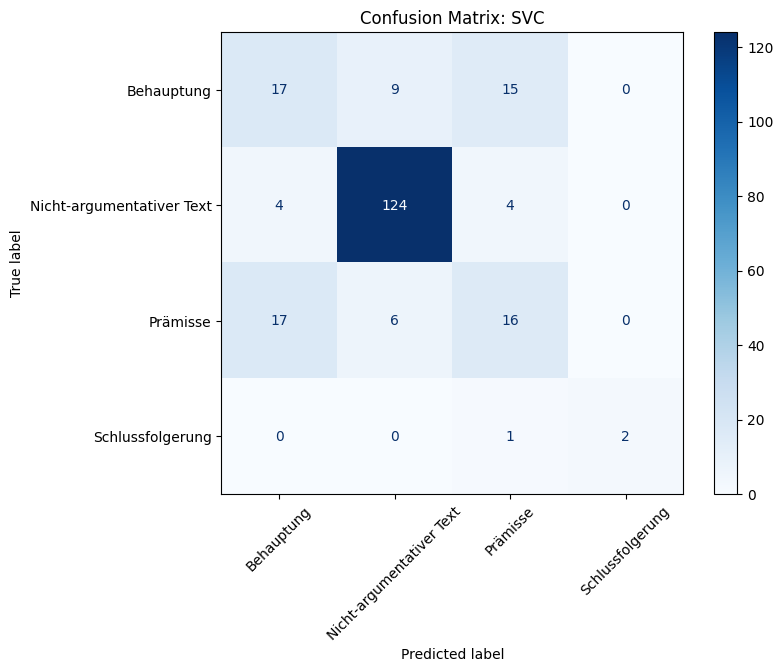

Number of misclassifications: 56

=== Evaluation for RandomForestClassifier ===
                           precision    recall  f1-score   support

               Behauptung       0.33      0.28      0.30        25
Nicht-argumentativer Text       0.90      0.91      0.91        79
                 Prämisse       0.41      0.48      0.44        23
         Schlussfolgerung       1.00      0.50      0.67         2

                 accuracy                           0.71       129
                macro avg       0.66      0.54      0.58       129
             weighted avg       0.70      0.71      0.70       129



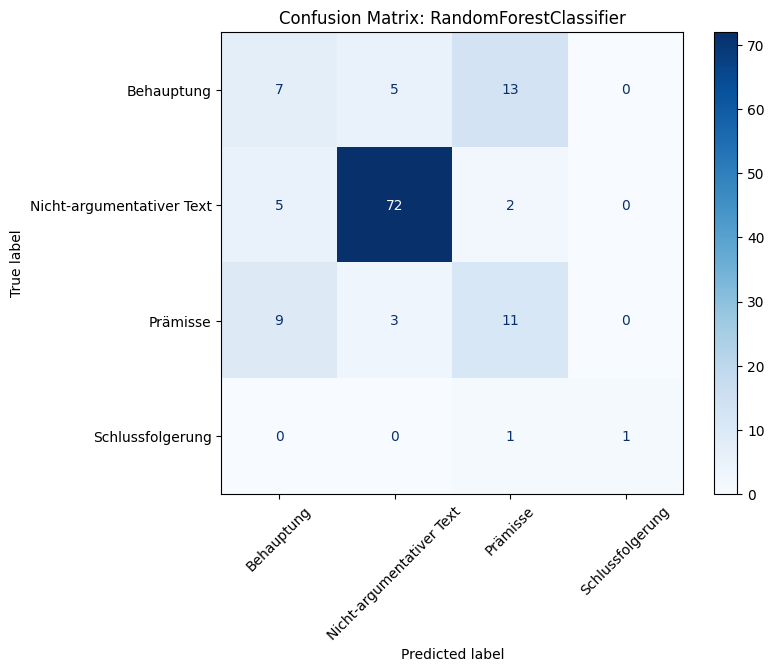

Number of misclassifications: 38

=== Evaluation for RandomForestClassifier ===
                           precision    recall  f1-score   support

               Behauptung       0.33      0.37      0.35        41
Nicht-argumentativer Text       0.90      0.86      0.88       132
                 Prämisse       0.36      0.41      0.39        39
         Schlussfolgerung       1.00      0.33      0.50         3

                 accuracy                           0.67       215
                macro avg       0.65      0.49      0.53       215
             weighted avg       0.70      0.67      0.68       215



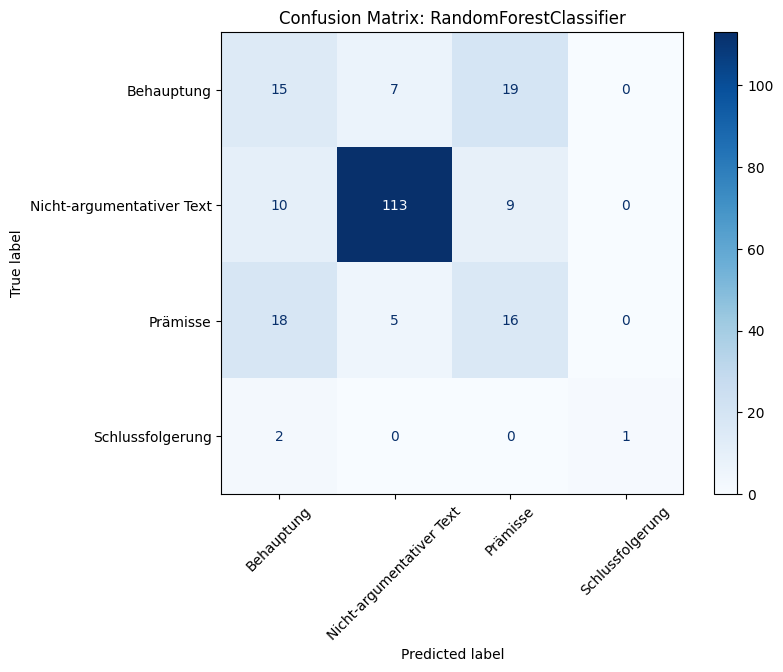

Number of misclassifications: 70

=== Evaluation for KNeighborsClassifier ===
                           precision    recall  f1-score   support

               Behauptung       0.42      0.56      0.48        25
Nicht-argumentativer Text       0.96      0.86      0.91        79
                 Prämisse       0.41      0.30      0.35        23
         Schlussfolgerung       0.12      0.50      0.20         2

                 accuracy                           0.70       129
                macro avg       0.48      0.56      0.48       129
             weighted avg       0.74      0.70      0.71       129



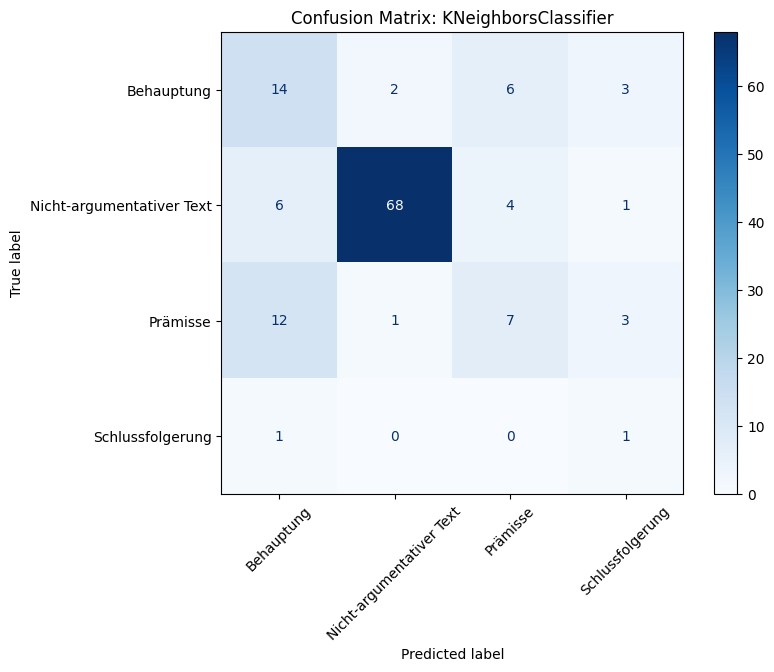

Number of misclassifications: 39

=== Evaluation for KNeighborsClassifier ===
                           precision    recall  f1-score   support

               Behauptung       0.35      0.49      0.41        41
Nicht-argumentativer Text       0.94      0.80      0.86       132
                 Prämisse       0.36      0.36      0.36        39
         Schlussfolgerung       0.29      0.67      0.40         3

                 accuracy                           0.66       215
                macro avg       0.48      0.58      0.51       215
             weighted avg       0.71      0.66      0.68       215



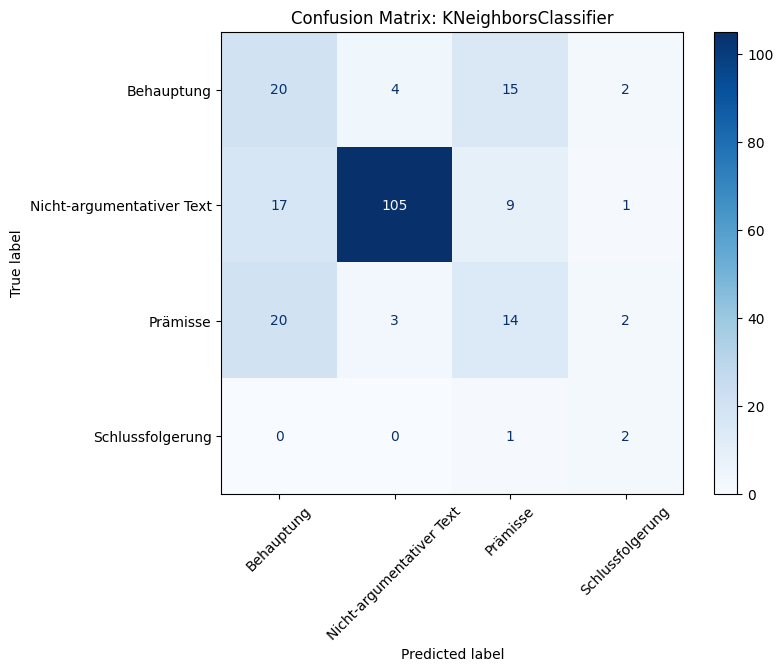

Number of misclassifications: 74


In [9]:
def evaluate_and_show(name, model, X_eval, y_eval, texts_eval, show_cm=True):
    y_pred = model.predict(X_eval)
    print(f"\n=== Evaluation for {name} ===")
    print(classification_report(y_eval, y_pred, target_names=le.classes_))
    if show_cm:
        cm = confusion_matrix(y_eval, y_pred)
        disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
        fig, ax = plt.subplots(figsize=(8,6))
        disp.plot(ax=ax, xticks_rotation=45, cmap=plt.cm.Blues)
        plt.title(f"Confusion Matrix: {name}")
        plt.show()

    # top misclassifications (first 20)
    mis_idx = np.where(y_eval != y_pred)[0]
    print(f"Number of misclassifications: {len(mis_idx)}")

# Evaluating each saved best model on validation and test
for name, mdl in best_models.items():
    evaluate_and_show(name, mdl, X_val, y_val, X_val_texts)
    evaluate_and_show(name, mdl, X_test, y_test, X_test_texts)